## Heston Model

### [Formula](https://en.wikipedia.org/wiki/Heston_model)

The price of the asset $S_t$ is determined by a stochastic process:

<center> $dS_{t}=\mu S_{t}\,dt+{\sqrt  {\nu_{t}}}S_{t}\,dW_{t}^{S}$ </center>

The instantaneous variance $\nu_t$ is a CIR process:

<center> $d\nu_{t}=\kappa (\theta -\nu_{t})\,dt+\xi {\sqrt  {\nu_{t}}}\,dW_{t}^{{\nu }}$ </center>

where $W_{t}^{S},W_{t}^{\nu }$ are Wiener processes (continuous random walks) with correlation $\rho$.

The parameters in the above equations represent the following:
- $\mu$ is the rate of return of the asset.
- $\theta$ is the long variance, or long run average price variance; as $t$ tends to infinity, the expected value of $\nu_t$ tends to $\theta$.
- $\kappa$ is the rate at which $\nu_t$ reverts to $\theta$.
- $\xi$ is the volatility of the volatility, or 'vol of vol', and determines the variance of $\nu_t$.

If $2\kappa \theta >\xi ^{2}$ (Feller condition), then the process $\nu_t$ is strictly positive.


### Discretization
Forward Euler for Heston model

<center> $\nu_{t} = \nu_{t-1} + \kappa (\theta -\nu_{t-1})\frac{T}{N} + \xi{\sqrt{|\nu_{t-1}|}}\sqrt{\frac{T}{N}} Z_{t}^{\nu}$ </center>

<center> $\log(S_t)= \log(S_{t-1}) -\frac{\nu_{t}^2}{2} \frac{T}{N} + \nu_{t} \sqrt{\frac{T}{N}} Z_{t}^{S}$ </center>


### Implementation Decisions (to be made)
- Initialization - does it matter in our case?
- Parameter tuning - maybe it doesn't matter in our case either
- What to do when v < 0? abs, trunc? Do we apply it to all v's in the formula?

### Some References
- https://www.degruyter.com/document/doi/10.1515/math-2017-0058/html#:~:text=The%20main%20parameters%20of%20interest,increases%20the%20prices%20of%20options
- https://www.quantstart.com/articles/Heston-Stochastic-Volatility-Model-with-Euler-Discretisation-in-C/
- https://arxiv.org/pdf/1502.02963.pdf
- https://www.valpo.edu/mathematics-statistics/files/2015/07/Estimating-Option-Prices-with-Heston%E2%80%99s--Stochastic-Volatility-Model.pdf
- Heston code (Michele mentioned it in the last meeting): https://github.com/daleroberts/heston/blob/master/heston.r

In [1]:
2*kappa*theta - sigma**2

NameError: name 'kappa' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import utils 
## Dimensions
m = 1           # dimention of output
Ktrain = 1000  # number of training models
N = 1000        # time disrectization
T = 1           # maturity
## Parameters
rho = -0.75     # correlation between the two process
kappa = 0.1     # kappa: reversion strength
theta = 0.2     # theta: long-term volatility
sigma = 0.1        # xi: volatility of volatility
## Initialization - could have other values
S0 = 100 * np.ones((Ktrain,m))
v0 = theta * np.ones((Ktrain,m))
price_path, vol_path = utils.stimulate_Heston(m,Ktrain,N,T,rho,kappa,theta,sigma,S0,v0)

In [ ]:
plt.hist(price_path[:,-1])

# The Greeks

### Main Reference

**Valuing European Option Using the Heston Model in QuantLib Python**

http://gouthamanbalaraman.com/blog/valuing-european-option-heston-model-quantLib.html

- kappa = 0.1   mean reversion strength 
- sigma = 0.1   vol of volatility 
- rho = -0.75   correlation between the asset price and its variance
- vol = 0.2     vol of the underlying stock (known to be 20%)
- v0 = vol^2 = 0.04   the spot variance 
- theta = v0    the mean reversion variance

### Some Other References

- QuantLib: setting up QuantLib-Python and pricing an option: https://www.quantopia.net/quantlib-setting-up-quantlib-python-and-pricing-an-option/
- Introducing QuantLib: Black-Scholes and the Greeks: https://mhittesdorf.wordpress.com/2013/07/29/introducing-quantlib-black-scholes-and-the-greeks/
- QuantLib, the Greeks and other useful option-related values: https://quantcorner.wordpress.com/2011/02/06/quantlib-the-greeks-and-other-useful-option-related-values/
- Heston Model: Formula, Assumptions, Limitations: https://blog.quantinsti.com/heston-model/

In [80]:
import QuantLib as ql
# option parameters
strike_price = 100.00
option_type = ql.Option.Call
maturity_date = ql.Date(31, 12, 2020)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

# parameters for Heston
kappa = 1  # mean reversion strength
sigma = 2  # vol of vol
rho = -0.7  # corr between asset price and var
v0 = 0.04   # historical vols for the stock
theta = 0.04   # mean reversion variance


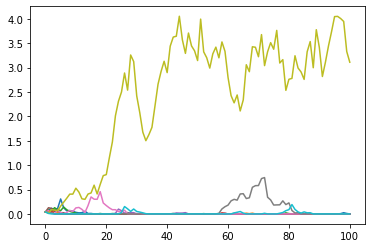

In [81]:
day_count = ql.Actual365Fixed()

calculation_date = ql.Date(1, 1, 2020)
spot_price = 100.00
# ql.Settings.instance().evaluationDate = calculation_date

# construct the yield curve
dividend_rate =  0
risk_free_rate = 0
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)

dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)

# set the spot price
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)

# calculate option price
heston_process = ql.HestonProcess(
flat_ts, dividend_yield, spot_handle,
v0, kappa, theta, sigma, rho
)


timestep = 100
length = 1
times = ql.TimeGrid(length, timestep)
dimension = heston_process.factors()
numPaths = 10

rng = ql.UniformRandomSequenceGenerator(dimension * timestep, ql.UniformRandomGenerator())
sequenceGenerator = ql.GaussianRandomSequenceGenerator(rng)
pathGenerator = ql.GaussianMultiPathGenerator(heston_process, list(times), sequenceGenerator, False)

# paths[0] will contain spot paths, paths[1] will contain vol paths
paths = [[] for i in range(dimension)]
for i in range(numPaths):
    samplePath = pathGenerator.next()
    values = samplePath.value()
    spot = values[0]

    for j in range(dimension):
        paths[j].append([x for x in values[j]])
        
import numpy as np
import matplotlib.pyplot as plt
paths_np = np.array(paths)
# plt.plot(paths_np[0,:,:].T)
plt.plot(paths_np[1,:,:].T)       

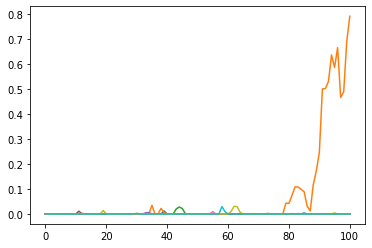

In [39]:

def heston_value(calculation_date, v0, spot_price):
    # set the evaluation date
    ql.Settings.instance().evaluationDate = calculation_date

    # construct the yield curve
    dividend_rate =  0
    risk_free_rate = 0
    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, risk_free_rate, day_count)
    )
    dividend_yield = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, dividend_rate, day_count)
    )

    # set the spot price
    spot_handle = ql.QuoteHandle(
        ql.SimpleQuote(spot_price)
    )
    
    # calculate option price
    heston_process = ql.HestonProcess(
    flat_ts, dividend_yield, spot_handle,
    v0, kappa, theta, sigma, rho
    )

    engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process),0.01, 1000)
    european_option.setPricingEngine(engine)
    h_price = european_option.NPV()
    
    return h_price

### Calculate the Greeks numerically
Use central finite difference

In [42]:
import numpy as np
import matplotlib.pyplot as plt
price = np.linspace(50,150,100)
DELTA = price*0
VEGA = price*0
PRICE = price*0
for i,p in enumerate(price): 
    p, delta, vega = calc_greeks(calculation_date, v0, p)
    PRICE[i] = p 
    DELTA[i] = delta
    VEGA[i] = vega

def smooth(PRICE):
    PRICE2 = PRICE*1
    for i,p in enumerate(PRICE):
        if i > 0 and i < 99:
            PRICE2[i] = PRICE[i-1]/3 + PRICE[i]/3 + PRICE[i+1]/3
    return PRICE2


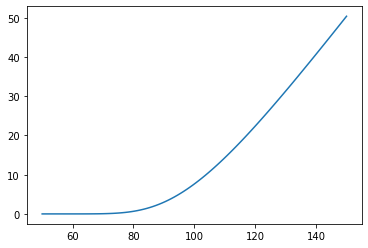

In [43]:
plt.plot(price,PRICE)

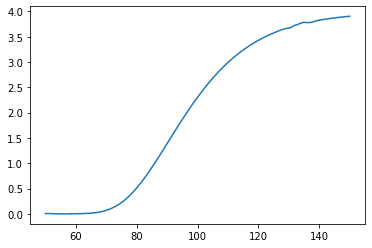

In [44]:
# dd = DELTA*1
# for i in range(10):
#     dd = smooth(dd)
plt.plot(price,DELTA)
# plt.plot(price,dd)

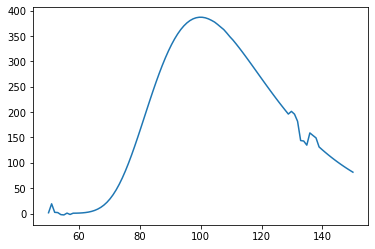

In [45]:
# vv = VEGA*1
# for i in range(10):
#     vv = smooth(vv)
plt.plot(price,VEGA)
# plt.plot(price,vv)

In [40]:
calculation_date = ql.Date(1, 1, 2020)
v0 = 0.04
spot_price = 100.00
price = heston_value(calculation_date, v0, spot_price)
print(price)


v0_delta = 0.001
spot_delta = 1

def calc_greeks(calculation_date, v0, spot_price):

    v0_plus  = v0 + v0_delta
    v0_minus = v0 - v0_delta
    spot_price_plus  = spot_price + spot_delta
    spot_price_minus = spot_price - spot_delta
    
    p_curr = heston_value(calculation_date, v0, spot_price)
    
    p_vega_plus  = heston_value(calculation_date, v0_plus,  spot_price)
    p_vega_minus = heston_value(calculation_date, v0_minus, spot_price)
    
    p_delta_plus  = heston_value(calculation_date, v0, spot_price_plus)
    p_delta_minus = heston_value(calculation_date, v0, spot_price_minus)
    
    delta = (p_delta_plus - p_delta_minus) / spot_delta * 2
    vega = (p_vega_plus - p_vega_minus) / v0_delta * 2
    
    return [p_curr, delta, vega]

calc_greeks(calculation_date, v0, spot_price)

7.6374942371858126


[7.6374942371858126, 2.3053300580551763, 387.0507122122149]